In [1]:
using Pkg
Pkg.activate("C:\\Users\\Alex\\Desktop\\repo\\2612\\0903\\dynamical-systems\\env\\integrate\\")

  Activating project at `C:\Users\Alex\Desktop\repo\2612\0903\dynamical-systems\env\integrate`


In [2]:
using StaticArrays, DifferentialEquations, DynamicalSystems

E, x, y  = 0..40, 0..1,  0..1
box = E × x × y
using CairoMakie

In [3]:
@inbounds U(y, p) = p[8] + p[9] / ( 1.0 + exp( -50.0 * (y - p[7]) ) )
@inbounds σ(x, p) = 1.0 / ( 1.0 + exp( -20.0 * (x-p[6]) ) )
@inbounds g(E, x, y, p, U_) = log( 1.0 + exp( (p[5] * U_ * x * E + p[11]  ) / (p[1]) ) )

@inbounds function TM(u, p, t)
    
    U_ = U(u[3], p)
    
    du1 = (-u[1] + p[1] * g(u[1], u[2], u[3], p, U_) ) / p[2]
    du2 = (1.0 - u[2]) / p[3] - U_*u[2]*u[1]
    du3 = (-u[3])/p[4] + p[10] * σ(u[2], p)
    
    return SVector(du1, du2, du3)
end


@inbounds function jacob_TM_(u, p, t)
    
    U(y, p, exp50) = p[8] + p[9] / ( 1.0 + exp50 )
    U_y(y, p, exp50) = (50.0 * p[9] * exp50) / (1.0 + exp50)^2
    g(E, x, y, p, U_) = exp((p[5]  * U_ * x * E + p[11]) / p[1])
    σ_der(x, p) = exp( (-20.0) * (x - p[6]) )
    exp50 = exp(-50.0 * (u[3] - p[7]))
    
    U_ = U(u[3], p, exp50)
    Uy = U_y(u[3], p, exp50)
    g_ = g(u[1], u[2], u[3], p, U_)
    σ_deri = σ_der(u[2], p)
    
    g_plus = 1.0 + g_
    g_mult = g_ * U_
    g_plus_mult = p[2] * (g_plus)
    u1p5 = p[5] * u[1]
    Uyu2 = Uy * u[2]
    
    E_E = (-1.0 + ((J * u[2] * g_mult)) / (g_plus) ) / p[2]
    E_x = (u1p5 * g_mult) / (g_plus_mult)
    E_y = (u1p5 * Uyu2 * g_) / (g_plus_mult)
    
    x_E = -U_ * u[2]
    x_x = -1.0 / p[3] - U_ * u[1]
    x_y = -Uyu2 * u[1]
    
    y_x = 20.0 * p[10] * σ_deri / (1.0 + σ_deri)^2
    y_y = -1.0/p[4]
    
    SMatrix{3,3}(E_E, x_E, 0.0,
        E_x, x_x, y_x,
        E_y, x_y, y_y)
end


function d(p1, p2)
    x1, y1, z1 = p1
    x2, y2, z2 = p2
    dist = sqrt( (x1-x2)^2 + (y1-y2)^2 + (z1-z2)^2 )
    return dist
end;

In [4]:
t = 2000; tt = 2000; tstep = 0.001
integ_set = (alg = RK4(), adaptive = false, dt = tstep);

Double period
[5.703960241685617, 0.7514489808165569, 0.44878444809941526]

Homoclinic
[6.154581240346446, 0.7336262321641008, 0.4403107515803029]

In [5]:
const τ = 0.013;  const τD = 0.080;  const τy = 3.3;  const J = 3.07;  const β = 0.300
const xthr = 0.75; const ythr = 0.4
const α = 1.58; const ΔU0 = 0.305;

U0 = 0.264
I0 = -1.7096


p = [α, τ, τD, τy, J, xthr, ythr, U0, ΔU0, β, I0]

u0_hc = [10.855370530818046, 0.6540230755971179, 0.44667500554157735] #[8.72034680045247, 0.7331126472077776, 0.439429357635731]
u0_2 =  [8.3288, 0.7386, 0.4390]# [6.154581240346446, 0.7336262321641008, 0.4403107515803029]

3-element Vector{Float64}:
 8.3288
 0.7386
 0.439

In [6]:
println(u0_hc)
println(u0_2)

[10.855370530818046, 0.6540230755971179, 0.44667500554157735]
[8.3288, 0.7386, 0.439]


In [7]:
ds_hc = CoupledODEs(TM, u0_hc, p, diffeq = integ_set)
tr_h, trange = trajectory(ds_hc, t, Δt = tstep; Ttr = tt)

ds_2 = CoupledODEs(TM, u0_2, p, diffeq = integ_set)
tr_2, trange = trajectory(ds_2, t, Δt = tstep; Ttr = tt)

fp, eigs, stable = fixedpoints(ds_hc, box, jacob_TM_)
eigs[1]

3-element Vector{ComplexF64}:
 -6.2835316636163245 + 0.0im
  2.1487424368553203 - 13.70180909174486im
  2.1487424368553203 + 13.70180909174486im

In [8]:
println(fp[1])

[8.327962854915322, 0.7386469831757736, 0.43904277314055995]


In [9]:
using GLMakie

In [10]:
lb_size = 35; tck_size = 20;

In [21]:
ts, tf = 1, 2000000
GLMakie.activate!()
f = Figure(resolution = (900, 600))
axis3 = Axis3(f[1, 1], xlabel = "x", ylabel = "y", zlabel = "E",
                xlabelsize = lb_size, ylabelsize = lb_size, zlabelsize = lb_size,
                xticklabelsize = tck_size, yticklabelsize = tck_size, zticklabelsize = tck_size,
                xgridvisible = false, ygridvisible = false, zgridvisible = false)
idx, idy, idz = 2, 3, 1

lines!(axis3, tr_h[ts:tf, idx], tr_h[ts:tf, idy], tr_h[ts:tf,idz], linewidth = 1.5, color = :deeppink)
lines!(axis3, tr_2[ts:tf, idx], tr_2[ts:tf, idy], tr_2[ts:tf,idz], linewidth = 1.5, color = :black)
scatter!(axis3, fp[1][idx], fp[1][idy], fp[1][idz], color = :deeppink)
display(f)

GLMakie.Screen(...)

In [12]:
distance = zeros(length(tr_2))

for i in range(1, length(distance), step = 1)
    distance[i] = d(tr_2[i], fp[1])
end
minimum(distance)

0.0020668461899142608

In [22]:
# black curve
lyapunovspectrum(ds_hc, t; Ttr = tt)

3-element Vector{Float64}:
 -0.00024776820425119695
 -0.13688966138533784
 -4.279660573173389

In [23]:
# pink curve
lyapunovspectrum(ds_2, t; Ttr = tt)

3-element Vector{Float64}:
 -0.0015919336859433297
 -0.13647745574241352
 -4.279554519876949

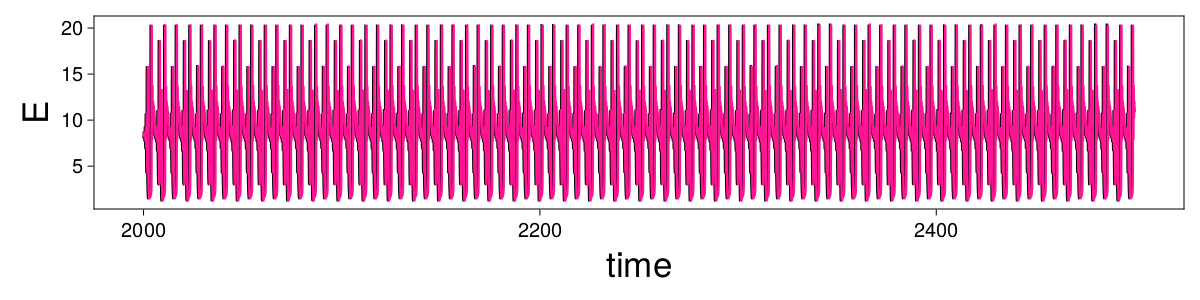

In [20]:
ts, tf = 1, 500000
CairoMakie.activate!()
f = Figure(resolution = (1200, 300))
axis = Axis(f[1, 1], xlabel = "time", ylabel = "E",
            xlabelsize = lb_size, ylabelsize = lb_size,
            xticklabelsize = tck_size, yticklabelsize = tck_size,
            xgridvisible = false, ygridvisible = false)
lines!(axis, trange[ts:tf], tr_2[ts:tf, 1], linewidth = 2.5, color = :black)
lines!(axis, trange[ts:tf], tr_h[ts:tf, 1], linewidth = 2.5, color = :deeppink)
f